In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial
from skmisc.loess import loess

from maskrcnn.postprocess.analysis import (
    control_for_spline, winsorize, demean)


np.random.seed(0)
matplotlib.rc('pdf', fonttype=42)

In [2]:
def plot(df, y, x, ylim,
         treat='treat',
         cmap={0: '#2c7bb6', 1: '#d7191c'}):
    df_nona = df.dropna(subset=[x, y]).sort_values(by=x)
    # regression
    results = smf.ols(y + ' ~ ' + treat, data=df_nona).fit()
    y_coef = results.params[treat]
    y_se = results.bse[treat]
    y_pvalue = results.pvalues[treat]
    results = smf.ols(x + ' ~ ' + treat, data=df_nona).fit()
    x_coef = results.params[treat]
    x_se = results.bse[treat]
    x_pvalue = results.pvalues[treat]
    results = smf.ols(y + ' ~ ' + x, data=df_nona).fit()
    scale = results.params[x]
    scale_se = results.bse[x]
    # calculate estimated effect
    est = y_coef / scale
    est_se = np.sqrt((y_se / y_coef) ** 2 + (scale_se / scale) ** 2) * abs(est)
    # make figure
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(6, 3))
    m = loess(df_nona[x].values, df_nona[y].values)
    m.fit()
    pred = m.predict(df_nona[x].values, stderror=True).confidence()
    ax0.plot(df_nona[x].values, pred.fit, color='dimgray', linewidth=1, alpha=0.4)
    ax0.fill_between(df_nona[x].values, pred.lower, pred.upper,
                     color='dimgray', alpha=.2)
    for cmap_value, cmap_color in cmap.items():
        y_col = df_nona.loc[df_nona[treat] == cmap_value, y]
        x_col = df_nona.loc[df_nona[treat] == cmap_value, x]
        m = loess(x_col, y_col)
        m.fit()
        pred = m.predict(x_col, stderror=True).confidence()
        ax0.plot(x_col, pred.fit, color=cmap_color, linewidth=2, alpha=0.8)
    ax0.set_title(
        f'N = {df_nona.shape[0]}\n' +
        f'Observed effects: {x_coef:.4f}\n' +
        f'x p-value: {x_pvalue:.4f}\n' +
        f'Estimated effects: {y_coef:.4f} / {scale:.4f} = {est:.4f}\n' +
        f'y p-value: {y_pvalue:.4f}\n')
    ax0.set_xlabel(x)
    ax0.set_ylabel(y)
    ax1.errorbar(0, est, yerr=1.96 * est_se, color='#d7191c',
                 capsize=3, fmt='--o')
    ax1.errorbar(1, x_coef, yerr=1.96 * x_se, color='#999999',
                 capsize=3, fmt='--o')
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Estimated', 'True'])
    ax1.set_xlim(-0.5, 1.5)
    ax1.set_ylim(*ylim)
    fig.savefig(os.path.join(OUT_DIR, f'{y}-{x}.pdf'))

In [3]:
palette = ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']

In [4]:
SVY_IN_DIR = 'data/External/GiveDirectly/GE_Luna_Extract_2020-04-20.dta'
SAT_IN_DIR = 'data/Siaya/Merged/sat.csv'

OUT_DIR = 'output/fig-engel'

In [5]:
# LOAD DATA
# load satellite data
df_sat = pd.read_csv(SAT_IN_DIR)
# create new var: luminosity
df_sat.loc[:, 'RGB_mean'] = df_sat.loc[:, ['R_mean', 'G_mean', 'B_mean']].mean(axis=1)
# control for lat lon cubic spline
df_sat.loc[:, 'RGB_mean_spline'] = control_for_spline(
    x=df_sat['centroid_lon'].values,
    y=df_sat['centroid_lat'].values,
    z=df_sat['RGB_mean'].values,
)
# convert unit
df_sat.loc[:, 'area'] *= ((0.001716 * 111000 / 800) ** 2)  # in sq meters

# load survey data
df_svy = pd.read_stata(SVY_IN_DIR)
print('Observations in raw data: ', df_svy.shape[0])

# drop households without geo coords
df_svy = df_svy.dropna(
    subset=['latitude', 'longitude'],
).reset_index(drop=True)
print('Observations w/ coords: ', df_svy.shape[0])

# calculate per capita consumption / assets
df_svy.loc[:, 'p2_consumption_wins_pc'] = (
    df_svy['p2_consumption_wins'].values / df_svy['hhsize1_BL'].values)
df_svy.loc[:, 'p1_assets_wins_pc'] = (
    df_svy['p1_assets_wins'].values / df_svy['hhsize1_BL'].values)

# log and winsorize more
df_svy.loc[:, 'logwins_p2_consumption_wins_pc'] = winsorize(
    df_svy['p2_consumption_wins_pc'], 2.5, 97.5
).apply(
    lambda x: np.log(x) if x > 0 else np.nan
)
df_svy.loc[:, 'logwins_p1_assets_wins_pc'] = winsorize(
    df_svy['p1_assets_wins_pc'], 2.5, 97.5
).apply(
    lambda x: np.log(x) if x > 0 else np.nan
)
# check missing
assert df_svy.loc[:, ['treat', 'hi_sat', 's1_hhid_key', 'satcluster']].notna().all().all()

# subset to eligible sample
df_svy = df_svy.loc[df_svy['h1_6_nonthatchedroof_BL'] == 0, :].reset_index(drop=True).copy()

Observations in raw data:  8239
Observations w/ coords:  7987
Winsorizing to 6060.708333333334 - 128418.99999999997
Winsorizing to 485.48750000000007 - 67205.75


In [6]:
# MATCHING
radius = 0.00045  # = 50m
k = 20  # no. of nearest neighbors examined

# match structures to households
# one structure is matched to one household at most
tree = scipy.spatial.cKDTree(
    df_svy.loc[:, ['longitude', 'latitude']].values)
dists, svy_idxes = tree.query(
    df_sat.loc[:, ['centroid_lon', 'centroid_lat']].values, k=k)
rank, sat_idxes = np.meshgrid(range(k), range(df_sat.shape[0]))
assert (dists[:, -1] > radius).all(), 'increase k value'

In [7]:
svy_idxes = svy_idxes[dists < radius]
sat_idxes = sat_idxes[dists < radius]
df = pd.concat([
    df_svy.loc[svy_idxes, ['s1_hhid_key']].reset_index(drop=True),
    df_sat.loc[sat_idxes, :].reset_index(drop=True),
    pd.DataFrame({'rank': rank[dists < radius],
                  'distance': dists[dists < radius]}),
], axis=1)
df = df.sort_values(by=['s1_hhid_key', 'distance'])

In [8]:
# option A: take the closest structure
df_close = df.drop_duplicates(subset=['s1_hhid_key'], keep='first')
df_close = pd.merge(df_svy, df_close, how='left', on=['s1_hhid_key'])
df_close.loc[:, 'area_pc'] = df_close['area'].values / df_close['hhsize1_BL'].values

In [9]:
# option B: take all the structures within the radius
df_circle = df.groupby('s1_hhid_key').agg(
    house_count=pd.NamedAgg(column='area', aggfunc='count'),
    area_sum=pd.NamedAgg(column='area', aggfunc='sum'),
    RGB_mean=pd.NamedAgg(column='RGB_mean', aggfunc='mean'),
    RGB_mean_spline=pd.NamedAgg(column='RGB_mean_spline', aggfunc='mean'),
).reset_index()
df_circle = pd.merge(df_svy, df_circle, how='left', on=['s1_hhid_key'])
df_circle.fillna({'house_count': 0, 'area_sum': 0}, inplace=True)
df_circle.loc[:, 'area_sum_pc'] = df_circle['area_sum'].values / df_circle['hhsize1_BL'].values
df_circle.loc[:, 'log1_area_sum_pc'] = df_circle['area_sum_pc'].apply(
    lambda x: np.log(x + 1) if x > 0 else np.nan
)

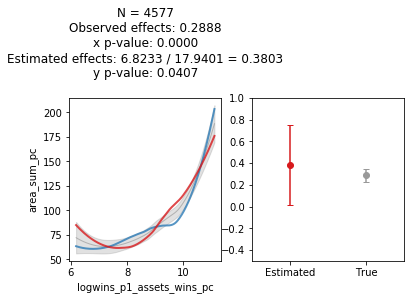

In [10]:
plot(
    df=df_circle,
    y='area_sum_pc',
    x='logwins_p1_assets_wins_pc',
    ylim=(-0.5, 1))

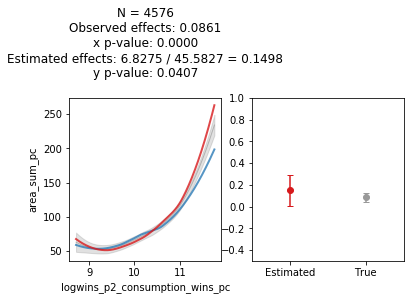

In [11]:
plot(
    df=df_circle,
    y='area_sum_pc',
    x='logwins_p2_consumption_wins_pc',
    ylim=(-0.5, 1))

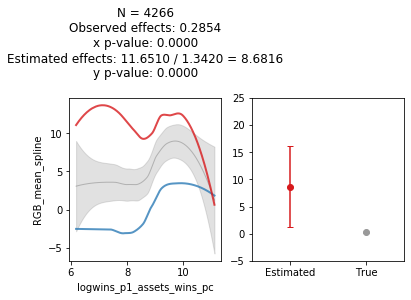

In [12]:
plot(
    df=df_close,
    y='RGB_mean_spline',
    x='logwins_p1_assets_wins_pc',
    ylim=(-5, 25))

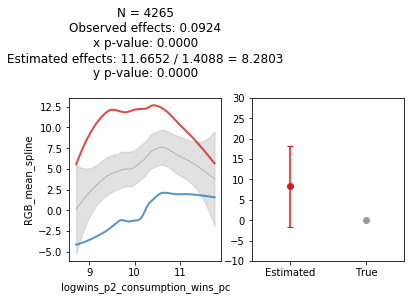

In [13]:
plot(
    df=df_close,
    y='RGB_mean_spline',
    x='logwins_p2_consumption_wins_pc',
    ylim=(-10, 30))